# **Building a Neural Network from Scratch - MNIST Dataset**


# Imprting Libraries


In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix, classification_report

# Implementation

In [2]:
"""Initialize layer weights and biases with different initialization strategies
   #1 Xavier initialization (better for tanh)
   #2 He initialization (better for ReLU)
   Bias set to 1 as required
   #3 Forward pass computation
"""
class Layer:
    def __init__(self, input_size, output_size, seed, initialization='xavier'):
        np.random.seed(seed)
        if initialization == 'xavier':
            self.weights = np.random.randn(input_size, output_size) * np.sqrt(1/input_size) #1
        elif initialization == 'he':
            self.weights = np.random.randn(input_size, output_size) * np.sqrt(2/input_size) #2
        else:
            self.weights = np.random.randn(input_size, output_size) * 0.01
        self.bias = np.ones((1, output_size))
        self.input = None
        self.output = None

    def forward(self, input_data): #3
        self.input = input_data
        self.output = np.dot(input_data, self.weights) + self.bias
        return self.output

# ReLu Activation

In [3]:
class ActivationReLU:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input_data):
        self.input = input_data
        self.output = np.maximum(0, input_data)
        return self.output

    def backward(self, dvalues):
        dinput = dvalues.copy()
        dinput[self.input <= 0] = 0
        return dinput

# Tanh Activation

In [4]:
class ActivationTanh:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input_data):
        self.input = input_data
        self.output = np.tanh(input_data)
        return self.output

    def backward(self, dvalues):
        return dvalues * (1 - np.square(self.output))

# LeakyReLu Activation

In [5]:
class ActivationLeakyReLU:
    def __init__(self, alpha=0.01):
        self.input = None
        self.output = None
        self.alpha = alpha

    def forward(self, input_data):
        self.input = input_data
        self.output = np.where(input_data > 0, input_data, self.alpha * input_data)
        return self.output

    def backward(self, dvalues):
        return np.where(self.input > 0, dvalues, dvalues * self.alpha)

# Softmax Activation

In [6]:
class ActivationSoftmax:
    def __init__(self):
        self.output = None

    def forward(self, input_data):
        exp_values = np.exp(input_data - np.max(input_data, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
        return self.output

# Applying Regularization - L2

In [7]:
"""Calculate cross-entropy loss with L2 regularization
   Add L2 regularization if layers are provided
"""

class LossCategoricalCrossentropy:
    def calculate(self, y_pred, y_true, layers=None, lambda_reg=0.01):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        else:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)

        negative_log_likelihoods = -np.log(correct_confidences)
        cross_entropy_loss = np.mean(negative_log_likelihoods)
        if layers is not None:
            l2_loss = 0
            for layer in layers:
                l2_loss += np.sum(np.square(layer.weights))
            l2_loss *= (lambda_reg / (2 * samples))
            return cross_entropy_loss + l2_loss

        return cross_entropy_loss

# Neural Network initialization

In [8]:
"""Initializing neural network with specified layer sizes and activation function
   #1 Create layers
   #2 Forward propagation
   #3 Compute gradients using backpropagation
   #4 Convert sparse labels to one-hot encoding
   Output layer gradient
   Backward pass through all layers
   Calculate gradients
   Store gradients
   Calculate error for next layer
Update network parameters using computed gradients
Evaluate model performance
"""

class NeuralNetwork:
    def __init__(self, layer_sizes, seed, activation='relu', initialization='xavier'):
        self.layers = []
        self.activations = []
        """#1"""
        for i in range(len(layer_sizes) - 1):
            self.layers.append(Layer(layer_sizes[i], layer_sizes[i+1], seed, initialization))
            if i < len(layer_sizes) - 2:
                if activation == 'relu':
                    self.activations.append(ActivationReLU())
                elif activation == 'tanh':
                    self.activations.append(ActivationTanh())
                elif activation == 'leaky_relu':
                    self.activations.append(ActivationLeakyReLU())
            else:
                self.activations.append(ActivationSoftmax())

        self.loss_function = LossCategoricalCrossentropy()

    def forward(self, X):
        """#2"""
        output = X
        for layer, activation in zip(self.layers, self.activations):
            output = layer.forward(output)
            output = activation.forward(output)
        return output

    def compute_gradients(self, X, y):
        samples = len(X)
        """#4"""
        if len(y.shape) == 1:
            y_one_hot = np.zeros((samples, self.layers[-1].weights.shape[1]))
            y_one_hot[range(samples), y] = 1
        else:
            y_one_hot = y
        gradients = []
        output_error = self.activations[-1].output - y_one_hot
        error = output_error
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            dweights = np.dot(layer.input.T, error) / samples
            dbias = np.sum(error, axis=0, keepdims=True) / samples
            gradients.append((dweights, dbias))
            if i > 0:
                error = np.dot(error, layer.weights.T)
                error = self.activations[i-1].backward(error)
        return list(reversed(gradients))

    def update_params(self, gradients, learning_rate):
        for i, layer in enumerate(self.layers):
            dweights, dbias = gradients[i]
            layer.weights -= learning_rate * dweights
            layer.bias -= learning_rate * dbias

    def evaluate(self, X_test, y_test):
        predictions = self.forward(X_test)
        test_loss = self.loss_function.calculate(predictions, y_test)
        test_accuracy = self.calculate_accuracy(predictions, y_test)
        y_pred = np.argmax(predictions, axis=1)
        if len(y_test.shape) > 1:
            y_true = np.argmax(y_test, axis=1)
        else:
            y_true = y_test
        report = classification_report(y_true, y_pred, output_dict=True)

        return {
            'test_loss': test_loss,
            'test_accuracy': test_accuracy,
            'classification_report': report
        }


    def train(self, X, y, batch_size, epochs, validation_split=0.2,
             early_stopping_patience=5, lambda_reg=0.01):

        """Train the neural network with early stopping and L2 regularization"""

        split_idx = int(len(X) * (1 - validation_split))
        X_train, X_val = X[:split_idx], X[split_idx:]
        y_train, y_val = y[:split_idx], y[split_idx:]

        best_val_loss = float('inf')
        patience_counter = 0
        best_weights = None

        history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

        for epoch in range(epochs):
            indices = np.random.permutation(len(X_train))
            X_train = X_train[indices]
            y_train = y_train[indices]

            """Mini-batch training"""
            for i in range(0, len(X_train), batch_size):
                batch_X = X_train[i:i + batch_size]
                batch_y = y_train[i:i + batch_size]

                """Forward pass"""
                predictions = self.forward(batch_X)
                gradients = self.compute_gradients(batch_X, batch_y)
                self.update_params(gradients, learning_rate=0.01)

            """Calculating epoch metrics with L2 regularization"""
            train_predictions = self.forward(X_train)
            train_loss = self.loss_function.calculate(
                train_predictions, y_train, self.layers, lambda_reg)
            train_accuracy = self.calculate_accuracy(train_predictions, y_train)

            val_predictions = self.forward(X_val)
            val_loss = self.loss_function.calculate(
                val_predictions, y_val, self.layers, lambda_reg)
            val_accuracy = self.calculate_accuracy(val_predictions, y_val)

            history['loss'].append(train_loss)
            history['accuracy'].append(train_accuracy)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_accuracy)

            """Early stopping check"""
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_weights = [(layer.weights.copy(), layer.bias.copy())
                              for layer in self.layers]
            else:
                patience_counter += 1

            if patience_counter >= early_stopping_patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                for layer, (weights, bias) in zip(self.layers, best_weights):
                    layer.weights = weights
                    layer.bias = bias
                break

            print(f"Epoch {epoch+1}/{epochs}")
            print(f"loss: {train_loss:.4f} - accuracy: {train_accuracy:.4f}")
            print(f"val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy:.4f}")

        return history

    def calculate_accuracy(self, predictions, y_true):
        """Calculate classification accuracy"""
        predicted_classes = np.argmax(predictions, axis=1)
        if len(y_true.shape) > 1:
            true_classes = np.argmax(y_true, axis=1)
        else:
            true_classes = y_true
        return np.mean(predicted_classes == true_classes)

    def get_params_count(self):
        """Calculate total trainable and non-trainable parameters"""
        trainable = 0
        for layer in self.layers:
            trainable += layer.weights.size + layer.bias.size
        return trainable, 0

# Load and preprocess of MNIST Dataset

In [9]:
def load_and_preprocess_mnist():
    """Load and preprocess MNIST dataset"""
    print("Loading MNIST dataset...")
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto', cache=True)
    X = np.array(X.astype('float32'))
    y = np.array(y.astype('int32'))
    X = X / 255.0
    print("Dataset loaded successfully!")
    print(f"X shape: {X.shape}, y shape: {y.shape}")
    return X, y

# Plotting Training History

In [10]:
def plot_training_history(history, split_ratio):
    """Plot training history"""
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss ({split_ratio*100}:{(1-split_ratio)*100} split)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model Accuracy ({split_ratio*100}:{(1-split_ratio)*100} split)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Confusion Matrix

In [11]:
def plot_confusion_matrix(y_true, y_pred):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# MNIST Dataset Training and Testing

Loading MNIST dataset...
Dataset loaded successfully!
X shape: (70000, 784), y shape: (70000,)

Training with 70.0:30.000000000000004 split

Testing relu activation with xavier initialization
Model Parameters - Trainable: 109,386, Non-trainable: 0
Epoch 1/25
loss: 0.3628 - accuracy: 0.8969
val_loss: 0.3762 - val_accuracy: 0.8914
Epoch 2/25
loss: 0.3051 - accuracy: 0.9109
val_loss: 0.3248 - val_accuracy: 0.9052
Epoch 3/25
loss: 0.2776 - accuracy: 0.9197
val_loss: 0.3029 - val_accuracy: 0.9095
Epoch 4/25
loss: 0.2565 - accuracy: 0.9267
val_loss: 0.2818 - val_accuracy: 0.9188
Epoch 5/25
loss: 0.2251 - accuracy: 0.9340
val_loss: 0.2598 - val_accuracy: 0.9224
Epoch 6/25
loss: 0.2060 - accuracy: 0.9396
val_loss: 0.2443 - val_accuracy: 0.9287
Epoch 7/25
loss: 0.1873 - accuracy: 0.9460
val_loss: 0.2265 - val_accuracy: 0.9343
Epoch 8/25
loss: 0.1757 - accuracy: 0.9492
val_loss: 0.2165 - val_accuracy: 0.9351
Epoch 9/25
loss: 0.1611 - accuracy: 0.9524
val_loss: 0.2040 - val_accuracy: 0.9382
Epoch

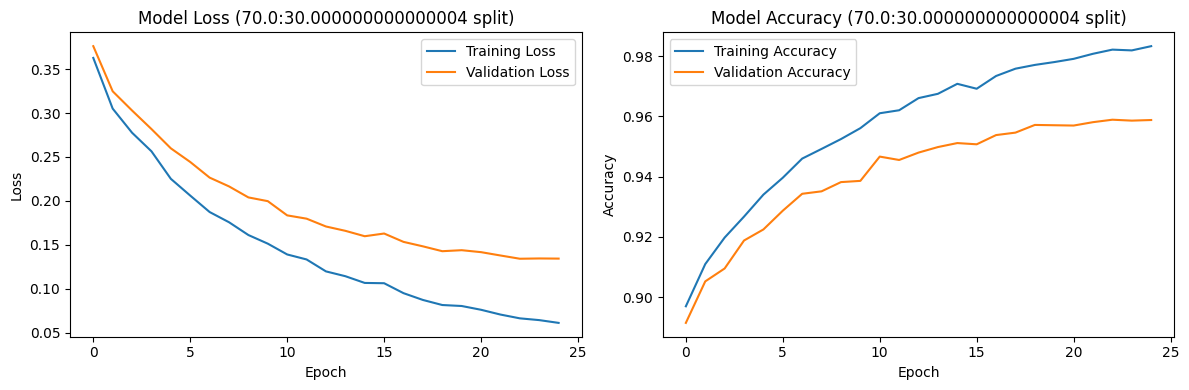

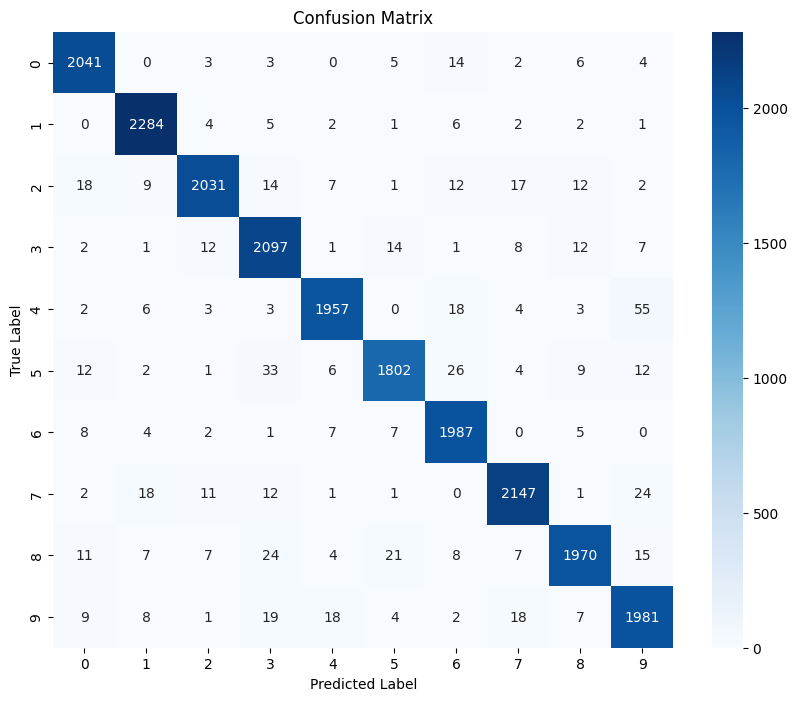


Testing relu activation with he initialization
Model Parameters - Trainable: 109,386, Non-trainable: 0
Epoch 1/25
loss: 0.3325 - accuracy: 0.9046
val_loss: 0.3496 - val_accuracy: 0.8977
Epoch 2/25
loss: 0.2802 - accuracy: 0.9190
val_loss: 0.3052 - val_accuracy: 0.9115
Epoch 3/25
loss: 0.2493 - accuracy: 0.9272
val_loss: 0.2795 - val_accuracy: 0.9167
Epoch 4/25
loss: 0.2215 - accuracy: 0.9365
val_loss: 0.2542 - val_accuracy: 0.9278
Epoch 5/25
loss: 0.1926 - accuracy: 0.9435
val_loss: 0.2339 - val_accuracy: 0.9306
Epoch 6/25
loss: 0.1748 - accuracy: 0.9494
val_loss: 0.2193 - val_accuracy: 0.9361
Epoch 7/25
loss: 0.1581 - accuracy: 0.9550
val_loss: 0.2045 - val_accuracy: 0.9405
Epoch 8/25
loss: 0.1476 - accuracy: 0.9577
val_loss: 0.1966 - val_accuracy: 0.9432
Epoch 9/25
loss: 0.1382 - accuracy: 0.9596
val_loss: 0.1905 - val_accuracy: 0.9419
Epoch 10/25
loss: 0.1273 - accuracy: 0.9646
val_loss: 0.1832 - val_accuracy: 0.9449
Epoch 11/25
loss: 0.1203 - accuracy: 0.9670
val_loss: 0.1723 - va

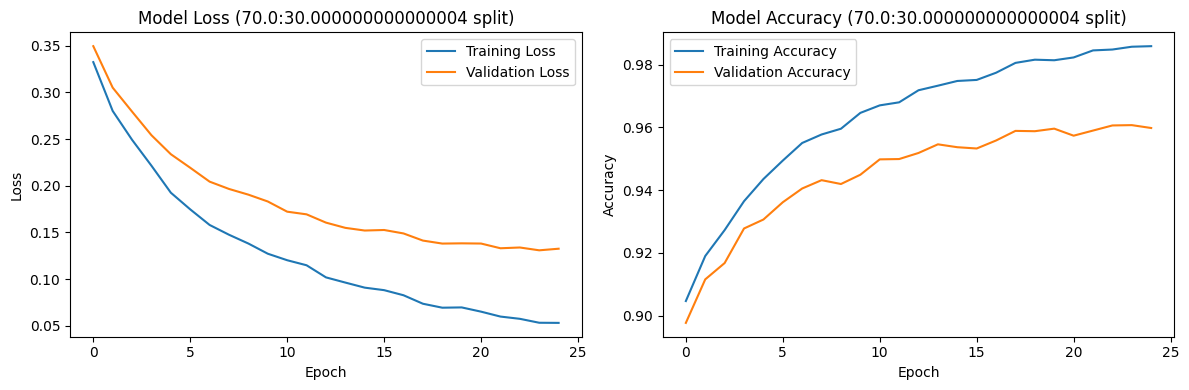

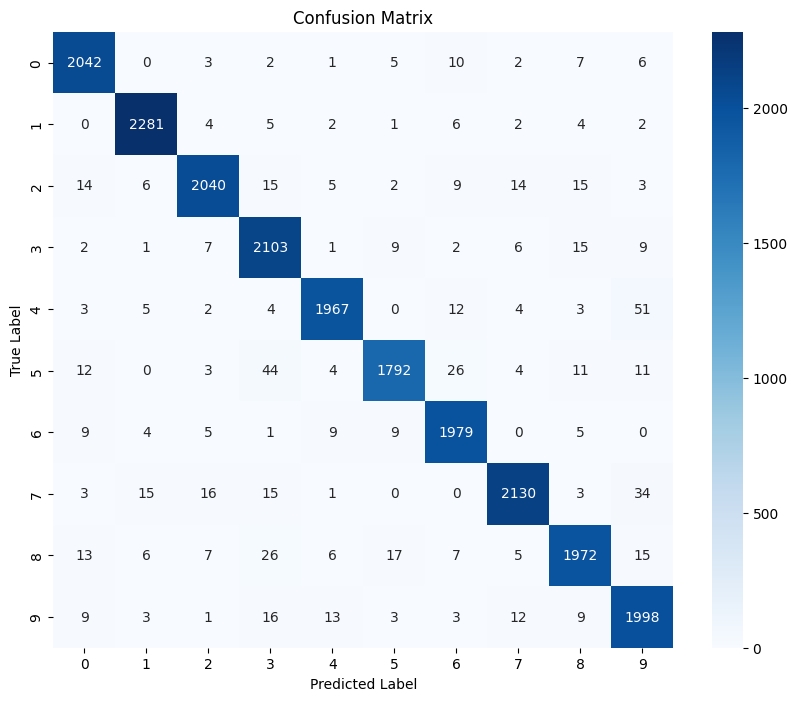


Testing tanh activation with xavier initialization
Model Parameters - Trainable: 109,386, Non-trainable: 0
Epoch 1/25
loss: 0.4615 - accuracy: 0.8824
val_loss: 0.4714 - val_accuracy: 0.8774
Epoch 2/25
loss: 0.3272 - accuracy: 0.9084
val_loss: 0.3431 - val_accuracy: 0.9007
Epoch 3/25
loss: 0.2809 - accuracy: 0.9190
val_loss: 0.3015 - val_accuracy: 0.9099
Epoch 4/25
loss: 0.2528 - accuracy: 0.9285
val_loss: 0.2768 - val_accuracy: 0.9181
Epoch 5/25
loss: 0.2259 - accuracy: 0.9349
val_loss: 0.2549 - val_accuracy: 0.9240
Epoch 6/25
loss: 0.2075 - accuracy: 0.9391
val_loss: 0.2397 - val_accuracy: 0.9289
Epoch 7/25
loss: 0.1906 - accuracy: 0.9448
val_loss: 0.2259 - val_accuracy: 0.9324
Epoch 8/25
loss: 0.1749 - accuracy: 0.9501
val_loss: 0.2109 - val_accuracy: 0.9369
Epoch 9/25
loss: 0.1623 - accuracy: 0.9528
val_loss: 0.2008 - val_accuracy: 0.9408
Epoch 10/25
loss: 0.1507 - accuracy: 0.9574
val_loss: 0.1913 - val_accuracy: 0.9419
Epoch 11/25
loss: 0.1402 - accuracy: 0.9606
val_loss: 0.1798 

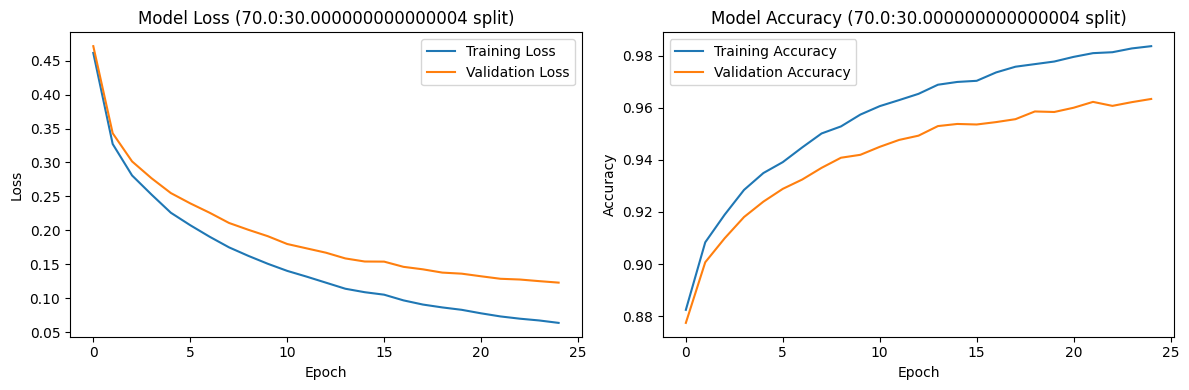

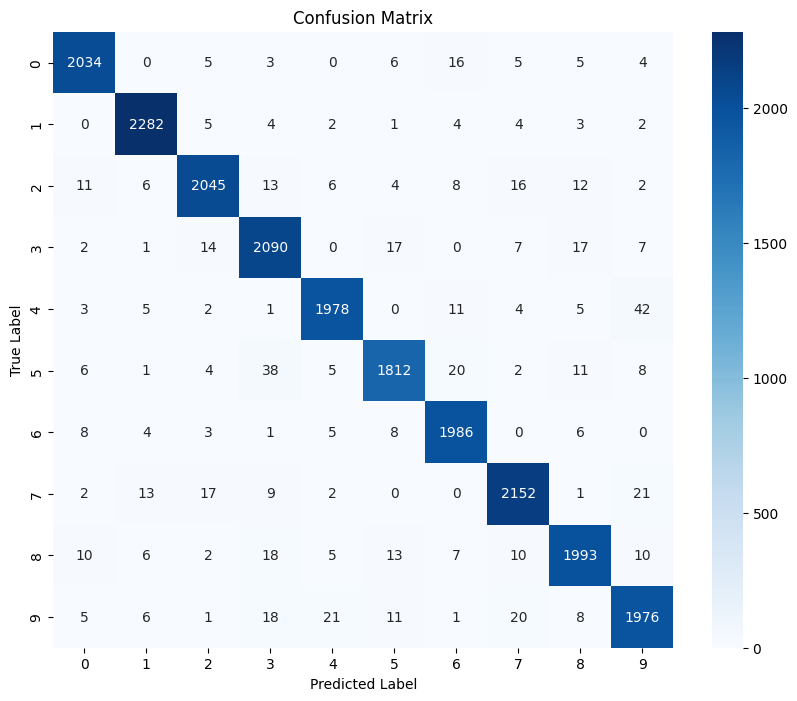


Testing tanh activation with he initialization
Model Parameters - Trainable: 109,386, Non-trainable: 0
Epoch 1/25
loss: 0.3913 - accuracy: 0.8962
val_loss: 0.4038 - val_accuracy: 0.8886
Epoch 2/25
loss: 0.2954 - accuracy: 0.9167
val_loss: 0.3139 - val_accuracy: 0.9081
Epoch 3/25
loss: 0.2543 - accuracy: 0.9270
val_loss: 0.2779 - val_accuracy: 0.9183
Epoch 4/25
loss: 0.2266 - accuracy: 0.9364
val_loss: 0.2530 - val_accuracy: 0.9250
Epoch 5/25
loss: 0.2006 - accuracy: 0.9427
val_loss: 0.2318 - val_accuracy: 0.9312
Epoch 6/25
loss: 0.1836 - accuracy: 0.9469
val_loss: 0.2183 - val_accuracy: 0.9360
Epoch 7/25
loss: 0.1674 - accuracy: 0.9528
val_loss: 0.2048 - val_accuracy: 0.9383
Epoch 8/25
loss: 0.1529 - accuracy: 0.9574
val_loss: 0.1916 - val_accuracy: 0.9433
Epoch 9/25
loss: 0.1423 - accuracy: 0.9595
val_loss: 0.1830 - val_accuracy: 0.9455
Epoch 10/25
loss: 0.1321 - accuracy: 0.9630
val_loss: 0.1747 - val_accuracy: 0.9478
Epoch 11/25
loss: 0.1230 - accuracy: 0.9660
val_loss: 0.1655 - va

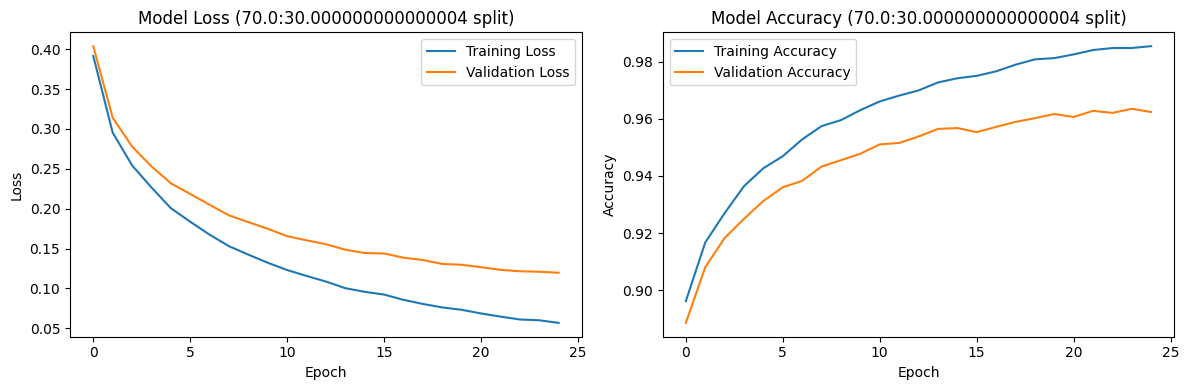

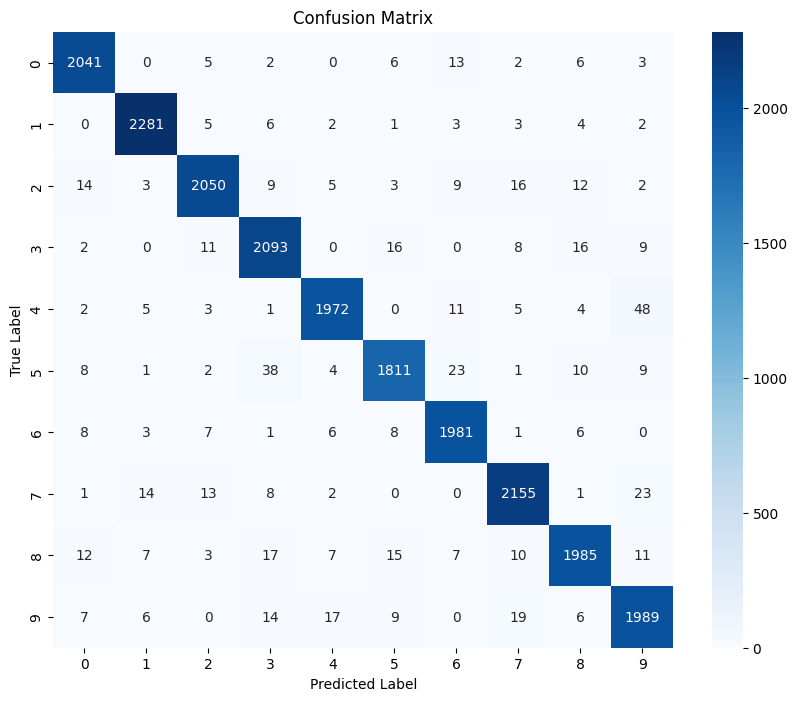


Testing leaky_relu activation with xavier initialization
Model Parameters - Trainable: 109,386, Non-trainable: 0
Epoch 1/25
loss: 0.3631 - accuracy: 0.8970
val_loss: 0.3765 - val_accuracy: 0.8906
Epoch 2/25
loss: 0.3054 - accuracy: 0.9107
val_loss: 0.3252 - val_accuracy: 0.9049
Epoch 3/25
loss: 0.2783 - accuracy: 0.9197
val_loss: 0.3035 - val_accuracy: 0.9099
Epoch 4/25
loss: 0.2573 - accuracy: 0.9265
val_loss: 0.2826 - val_accuracy: 0.9186
Epoch 5/25
loss: 0.2261 - accuracy: 0.9339
val_loss: 0.2608 - val_accuracy: 0.9220
Epoch 6/25
loss: 0.2070 - accuracy: 0.9393
val_loss: 0.2452 - val_accuracy: 0.9284
Epoch 7/25
loss: 0.1884 - accuracy: 0.9459
val_loss: 0.2275 - val_accuracy: 0.9344
Epoch 8/25
loss: 0.1769 - accuracy: 0.9486
val_loss: 0.2176 - val_accuracy: 0.9350
Epoch 9/25
loss: 0.1621 - accuracy: 0.9521
val_loss: 0.2051 - val_accuracy: 0.9376
Epoch 10/25
loss: 0.1523 - accuracy: 0.9556
val_loss: 0.2006 - val_accuracy: 0.9378
Epoch 11/25
loss: 0.1399 - accuracy: 0.9608
val_loss: 0

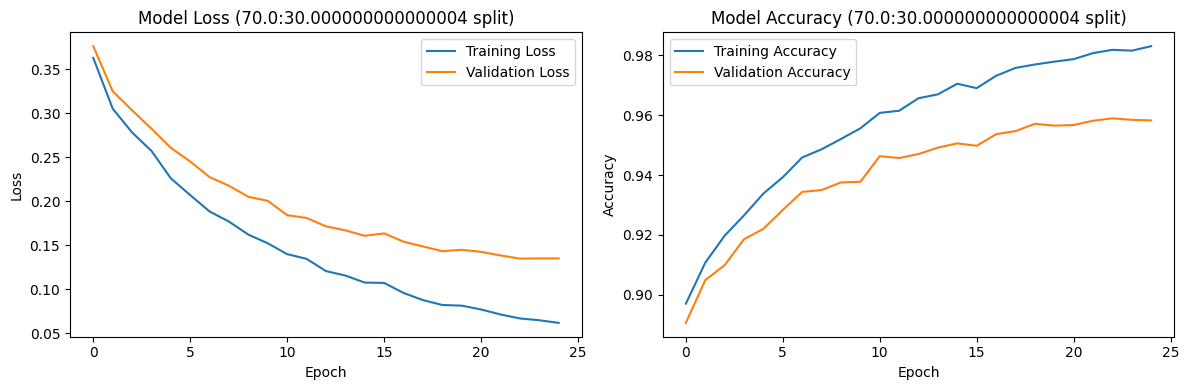

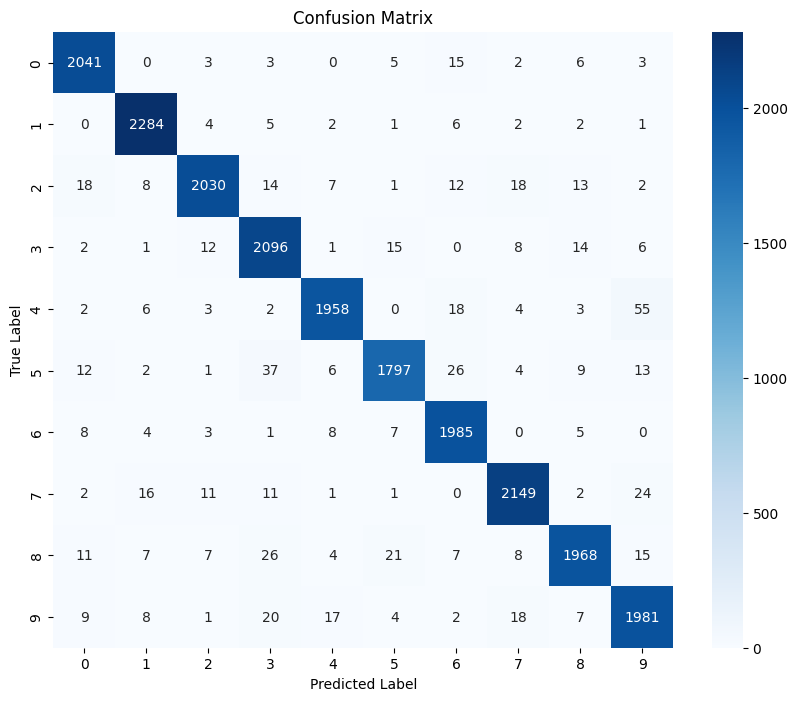


Testing leaky_relu activation with he initialization
Model Parameters - Trainable: 109,386, Non-trainable: 0
Epoch 1/25
loss: 0.3323 - accuracy: 0.9045
val_loss: 0.3492 - val_accuracy: 0.8982
Epoch 2/25
loss: 0.2809 - accuracy: 0.9188
val_loss: 0.3056 - val_accuracy: 0.9114
Epoch 3/25
loss: 0.2492 - accuracy: 0.9271
val_loss: 0.2793 - val_accuracy: 0.9168
Epoch 4/25
loss: 0.2225 - accuracy: 0.9365
val_loss: 0.2550 - val_accuracy: 0.9276
Epoch 5/25
loss: 0.1932 - accuracy: 0.9434
val_loss: 0.2343 - val_accuracy: 0.9300
Epoch 6/25
loss: 0.1754 - accuracy: 0.9492
val_loss: 0.2200 - val_accuracy: 0.9355
Epoch 7/25
loss: 0.1583 - accuracy: 0.9554
val_loss: 0.2045 - val_accuracy: 0.9405
Epoch 8/25
loss: 0.1487 - accuracy: 0.9574
val_loss: 0.1977 - val_accuracy: 0.9430
Epoch 9/25
loss: 0.1387 - accuracy: 0.9595
val_loss: 0.1909 - val_accuracy: 0.9408
Epoch 10/25
loss: 0.1274 - accuracy: 0.9642
val_loss: 0.1828 - val_accuracy: 0.9447
Epoch 11/25
loss: 0.1207 - accuracy: 0.9670
val_loss: 0.172

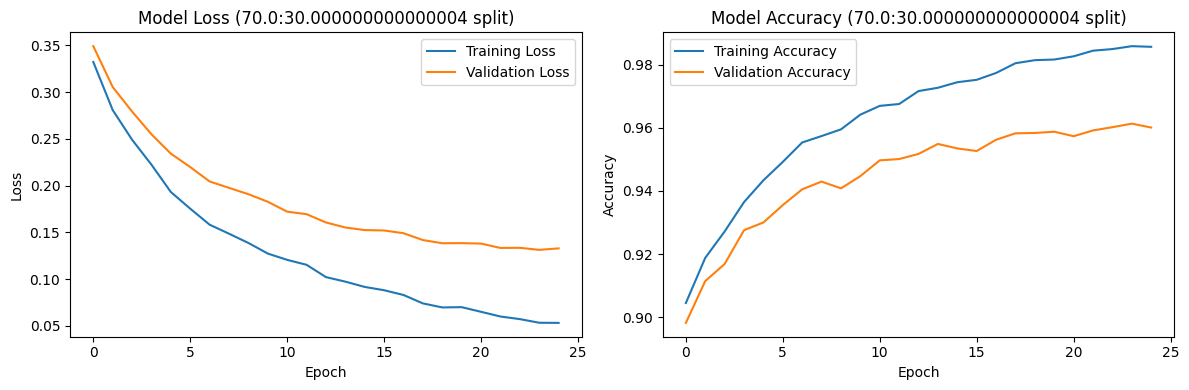

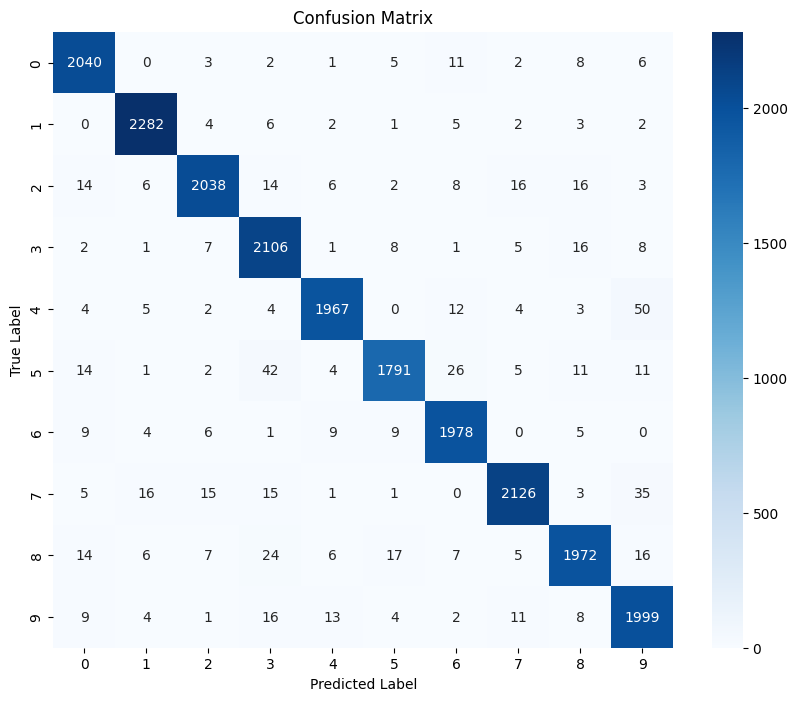


Training with 80.0:19.999999999999996 split

Testing relu activation with xavier initialization
Model Parameters - Trainable: 109,386, Non-trainable: 0
Epoch 1/25
loss: 0.3480 - accuracy: 0.9006
val_loss: 0.3618 - val_accuracy: 0.8958
Epoch 2/25
loss: 0.2987 - accuracy: 0.9134
val_loss: 0.3221 - val_accuracy: 0.9059
Epoch 3/25
loss: 0.2621 - accuracy: 0.9234
val_loss: 0.2891 - val_accuracy: 0.9170
Epoch 4/25
loss: 0.2351 - accuracy: 0.9310
val_loss: 0.2669 - val_accuracy: 0.9229
Epoch 5/25
loss: 0.2128 - accuracy: 0.9389
val_loss: 0.2474 - val_accuracy: 0.9296
Epoch 6/25
loss: 0.1926 - accuracy: 0.9439
val_loss: 0.2286 - val_accuracy: 0.9356
Epoch 7/25
loss: 0.1783 - accuracy: 0.9479
val_loss: 0.2168 - val_accuracy: 0.9390
Epoch 8/25
loss: 0.1600 - accuracy: 0.9536
val_loss: 0.2029 - val_accuracy: 0.9415
Epoch 9/25
loss: 0.1476 - accuracy: 0.9573
val_loss: 0.1894 - val_accuracy: 0.9454
Epoch 10/25
loss: 0.1403 - accuracy: 0.9590
val_loss: 0.1858 - val_accuracy: 0.9465
Epoch 11/25
loss

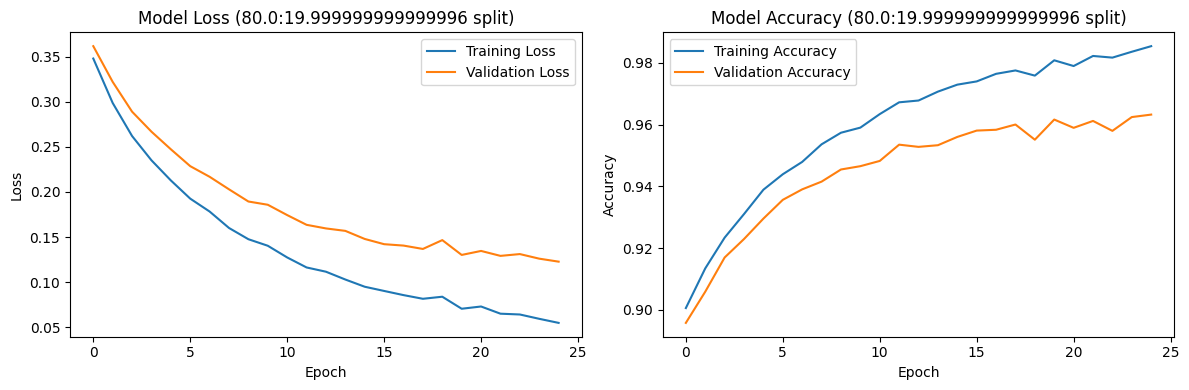

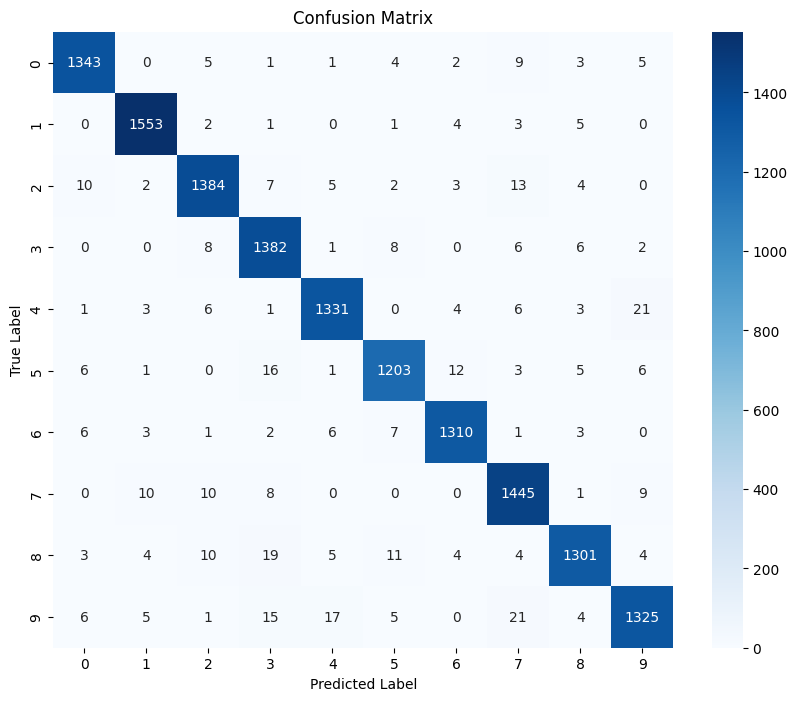


Testing relu activation with he initialization
Model Parameters - Trainable: 109,386, Non-trainable: 0
Epoch 1/25
loss: 0.3208 - accuracy: 0.9077
val_loss: 0.3377 - val_accuracy: 0.9044
Epoch 2/25
loss: 0.2732 - accuracy: 0.9205
val_loss: 0.3005 - val_accuracy: 0.9125
Epoch 3/25
loss: 0.2338 - accuracy: 0.9323
val_loss: 0.2646 - val_accuracy: 0.9246
Epoch 4/25
loss: 0.2046 - accuracy: 0.9401
val_loss: 0.2412 - val_accuracy: 0.9320
Epoch 5/25
loss: 0.1829 - accuracy: 0.9477
val_loss: 0.2227 - val_accuracy: 0.9357
Epoch 6/25
loss: 0.1652 - accuracy: 0.9529
val_loss: 0.2055 - val_accuracy: 0.9409
Epoch 7/25
loss: 0.1531 - accuracy: 0.9558
val_loss: 0.1969 - val_accuracy: 0.9416
Epoch 8/25
loss: 0.1390 - accuracy: 0.9602
val_loss: 0.1865 - val_accuracy: 0.9456
Epoch 9/25
loss: 0.1264 - accuracy: 0.9637
val_loss: 0.1753 - val_accuracy: 0.9482
Epoch 10/25
loss: 0.1213 - accuracy: 0.9652
val_loss: 0.1711 - val_accuracy: 0.9499
Epoch 11/25
loss: 0.1106 - accuracy: 0.9679
val_loss: 0.1626 - va

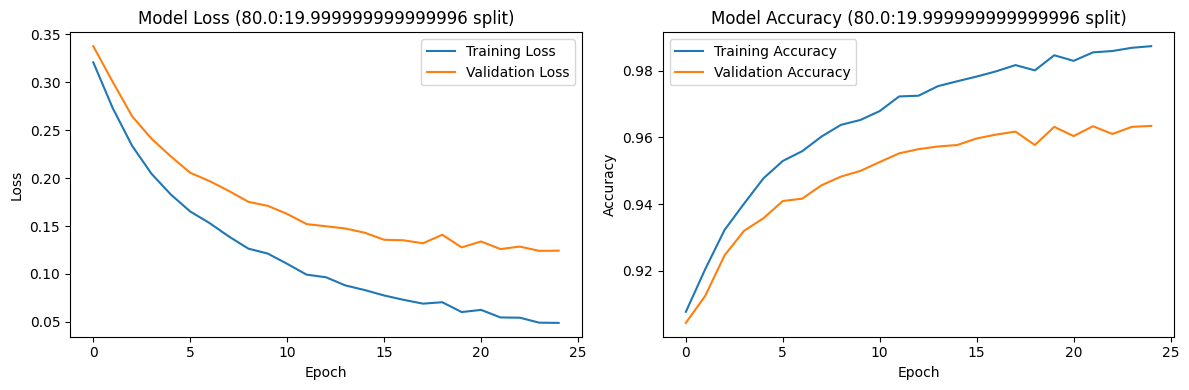

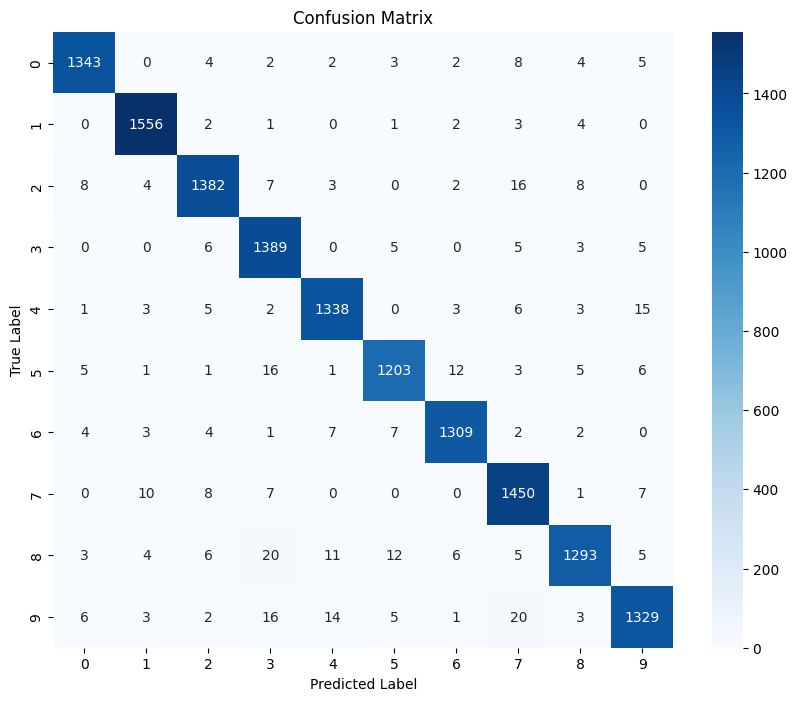


Testing tanh activation with xavier initialization
Model Parameters - Trainable: 109,386, Non-trainable: 0
Epoch 1/25
loss: 0.4287 - accuracy: 0.8879
val_loss: 0.4379 - val_accuracy: 0.8831
Epoch 2/25
loss: 0.3132 - accuracy: 0.9106
val_loss: 0.3322 - val_accuracy: 0.9029
Epoch 3/25
loss: 0.2697 - accuracy: 0.9224
val_loss: 0.2927 - val_accuracy: 0.9151
Epoch 4/25
loss: 0.2392 - accuracy: 0.9313
val_loss: 0.2664 - val_accuracy: 0.9217
Epoch 5/25
loss: 0.2163 - accuracy: 0.9381
val_loss: 0.2460 - val_accuracy: 0.9269
Epoch 6/25
loss: 0.1948 - accuracy: 0.9438
val_loss: 0.2252 - val_accuracy: 0.9337
Epoch 7/25
loss: 0.1778 - accuracy: 0.9485
val_loss: 0.2101 - val_accuracy: 0.9379
Epoch 8/25
loss: 0.1630 - accuracy: 0.9524
val_loss: 0.1981 - val_accuracy: 0.9418
Epoch 9/25
loss: 0.1493 - accuracy: 0.9570
val_loss: 0.1855 - val_accuracy: 0.9461
Epoch 10/25
loss: 0.1415 - accuracy: 0.9590
val_loss: 0.1787 - val_accuracy: 0.9463
Epoch 11/25
loss: 0.1295 - accuracy: 0.9628
val_loss: 0.1681 

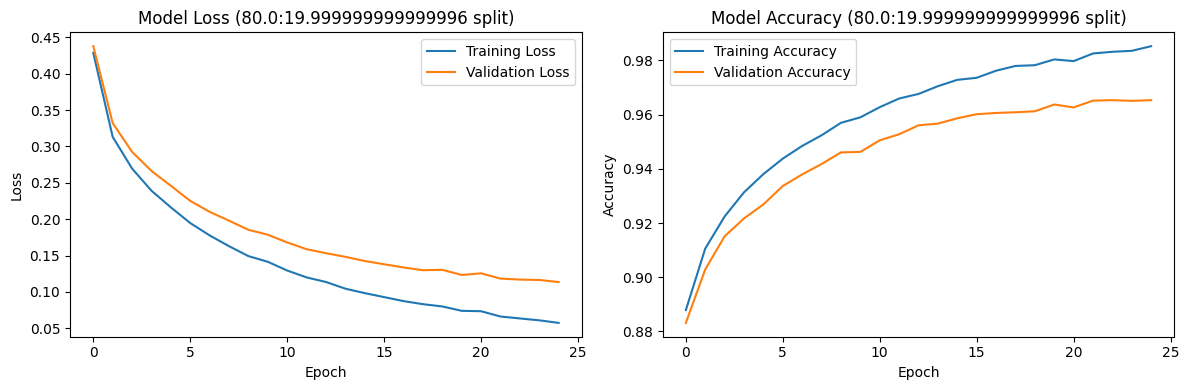

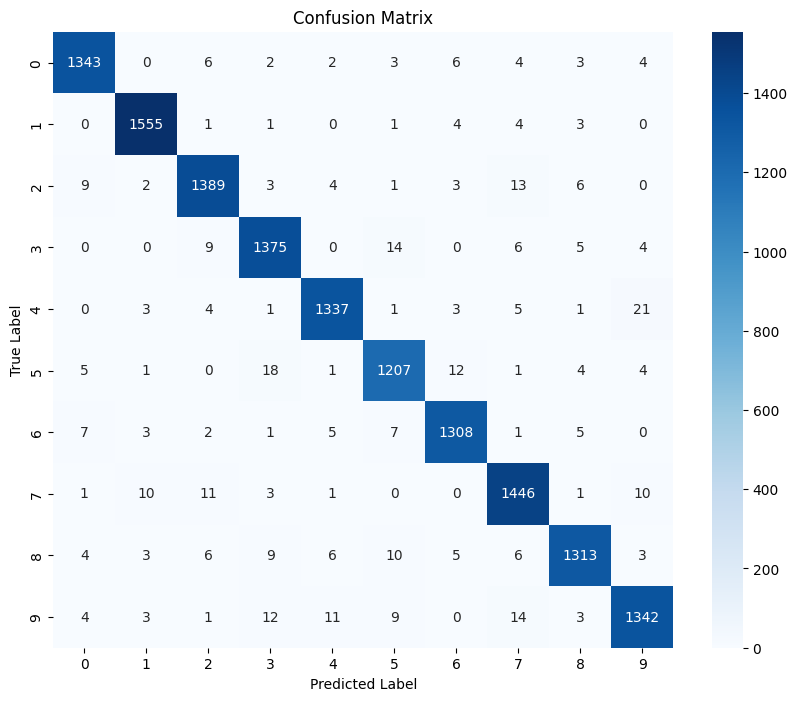


Testing tanh activation with he initialization
Model Parameters - Trainable: 109,386, Non-trainable: 0
Epoch 1/25
loss: 0.3699 - accuracy: 0.8994
val_loss: 0.3842 - val_accuracy: 0.8938
Epoch 2/25
loss: 0.2846 - accuracy: 0.9187
val_loss: 0.3078 - val_accuracy: 0.9099
Epoch 3/25
loss: 0.2447 - accuracy: 0.9303
val_loss: 0.2707 - val_accuracy: 0.9200
Epoch 4/25
loss: 0.2144 - accuracy: 0.9394
val_loss: 0.2440 - val_accuracy: 0.9262
Epoch 5/25
loss: 0.1918 - accuracy: 0.9454
val_loss: 0.2239 - val_accuracy: 0.9333
Epoch 6/25
loss: 0.1714 - accuracy: 0.9513
val_loss: 0.2039 - val_accuracy: 0.9384
Epoch 7/25
loss: 0.1565 - accuracy: 0.9553
val_loss: 0.1911 - val_accuracy: 0.9424
Epoch 8/25
loss: 0.1440 - accuracy: 0.9590
val_loss: 0.1815 - val_accuracy: 0.9463
Epoch 9/25
loss: 0.1315 - accuracy: 0.9636
val_loss: 0.1699 - val_accuracy: 0.9491
Epoch 10/25
loss: 0.1247 - accuracy: 0.9645
val_loss: 0.1639 - val_accuracy: 0.9521
Epoch 11/25
loss: 0.1151 - accuracy: 0.9672
val_loss: 0.1557 - va

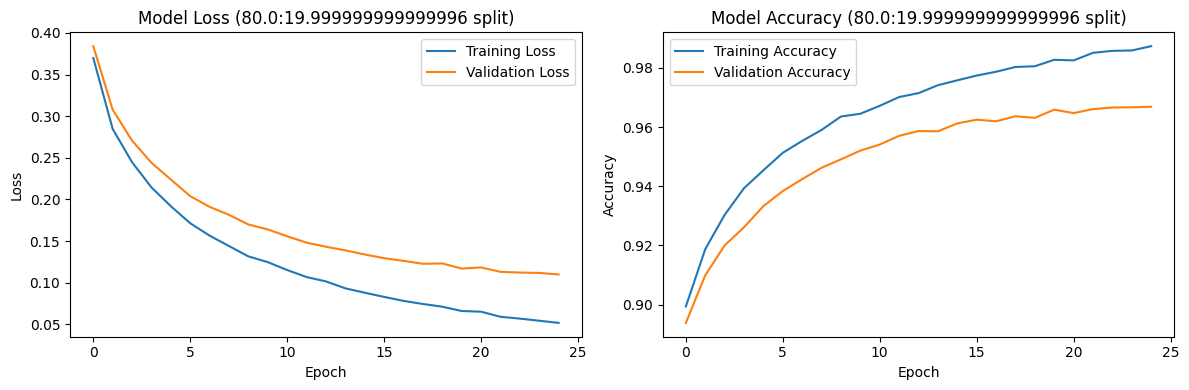

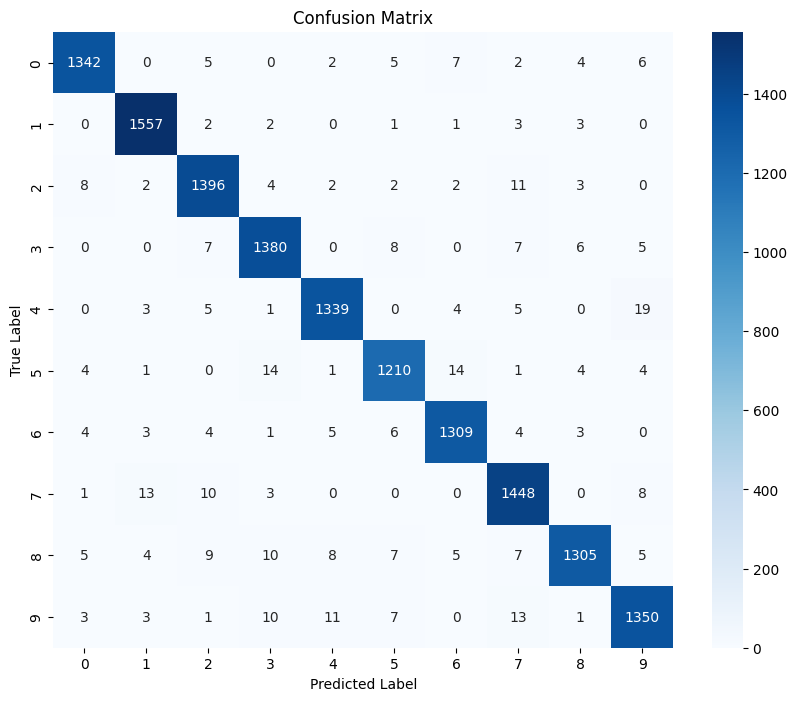


Testing leaky_relu activation with xavier initialization
Model Parameters - Trainable: 109,386, Non-trainable: 0
Epoch 1/25
loss: 0.3478 - accuracy: 0.9006
val_loss: 0.3615 - val_accuracy: 0.8954
Epoch 2/25
loss: 0.2986 - accuracy: 0.9137
val_loss: 0.3219 - val_accuracy: 0.9058
Epoch 3/25
loss: 0.2624 - accuracy: 0.9231
val_loss: 0.2894 - val_accuracy: 0.9171
Epoch 4/25
loss: 0.2356 - accuracy: 0.9306
val_loss: 0.2673 - val_accuracy: 0.9226
Epoch 5/25
loss: 0.2134 - accuracy: 0.9387
val_loss: 0.2479 - val_accuracy: 0.9291
Epoch 6/25
loss: 0.1933 - accuracy: 0.9435
val_loss: 0.2291 - val_accuracy: 0.9354
Epoch 7/25
loss: 0.1791 - accuracy: 0.9477
val_loss: 0.2176 - val_accuracy: 0.9386
Epoch 8/25
loss: 0.1607 - accuracy: 0.9533
val_loss: 0.2035 - val_accuracy: 0.9416
Epoch 9/25
loss: 0.1484 - accuracy: 0.9571
val_loss: 0.1903 - val_accuracy: 0.9449
Epoch 10/25
loss: 0.1413 - accuracy: 0.9583
val_loss: 0.1870 - val_accuracy: 0.9459
Epoch 11/25
loss: 0.1282 - accuracy: 0.9629
val_loss: 0

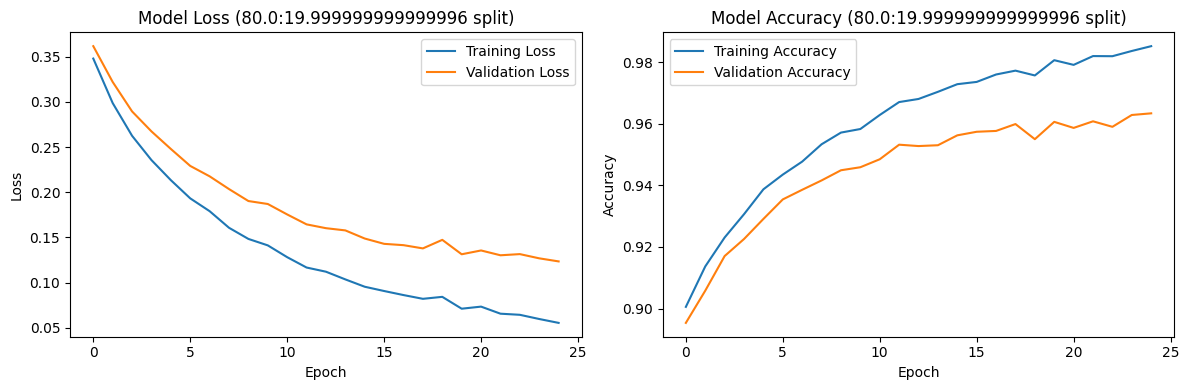

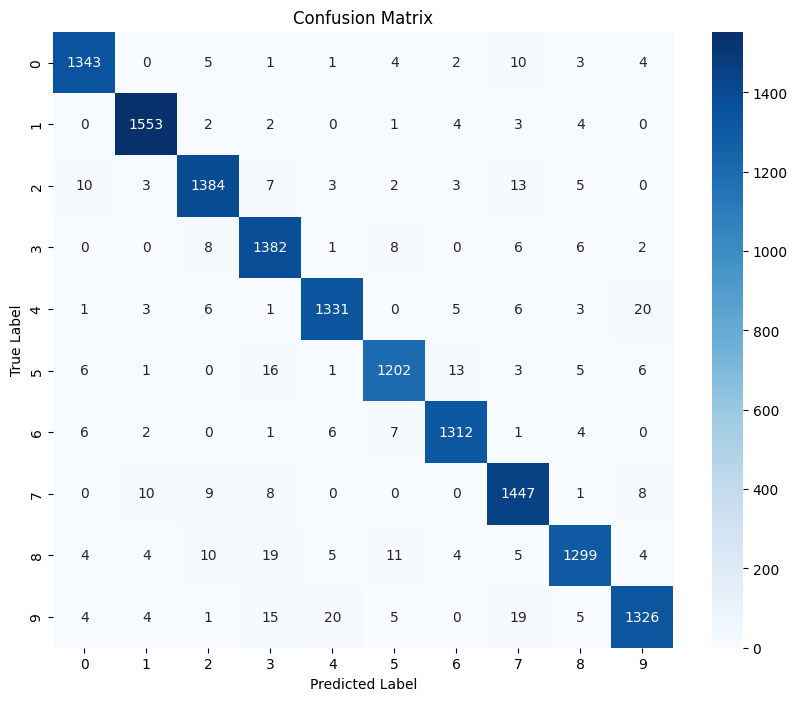


Testing leaky_relu activation with he initialization
Model Parameters - Trainable: 109,386, Non-trainable: 0
Epoch 1/25
loss: 0.3206 - accuracy: 0.9078
val_loss: 0.3376 - val_accuracy: 0.9043
Epoch 2/25
loss: 0.2737 - accuracy: 0.9204
val_loss: 0.3010 - val_accuracy: 0.9125
Epoch 3/25
loss: 0.2343 - accuracy: 0.9323
val_loss: 0.2652 - val_accuracy: 0.9242
Epoch 4/25
loss: 0.2055 - accuracy: 0.9400
val_loss: 0.2424 - val_accuracy: 0.9317
Epoch 5/25
loss: 0.1839 - accuracy: 0.9473
val_loss: 0.2236 - val_accuracy: 0.9354
Epoch 6/25
loss: 0.1664 - accuracy: 0.9525
val_loss: 0.2070 - val_accuracy: 0.9403
Epoch 7/25
loss: 0.1537 - accuracy: 0.9556
val_loss: 0.1977 - val_accuracy: 0.9413
Epoch 8/25
loss: 0.1395 - accuracy: 0.9602
val_loss: 0.1872 - val_accuracy: 0.9455
Epoch 9/25
loss: 0.1273 - accuracy: 0.9639
val_loss: 0.1761 - val_accuracy: 0.9479
Epoch 10/25
loss: 0.1219 - accuracy: 0.9650
val_loss: 0.1718 - val_accuracy: 0.9491
Epoch 11/25
loss: 0.1113 - accuracy: 0.9679
val_loss: 0.163

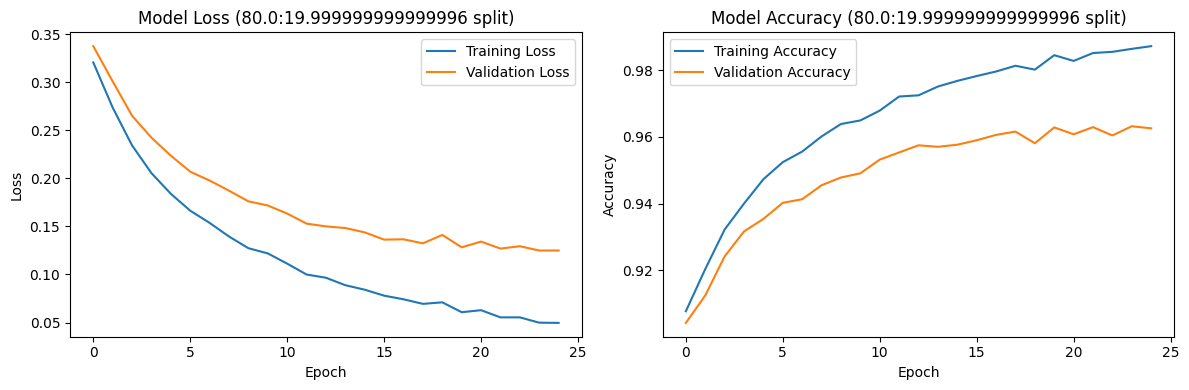

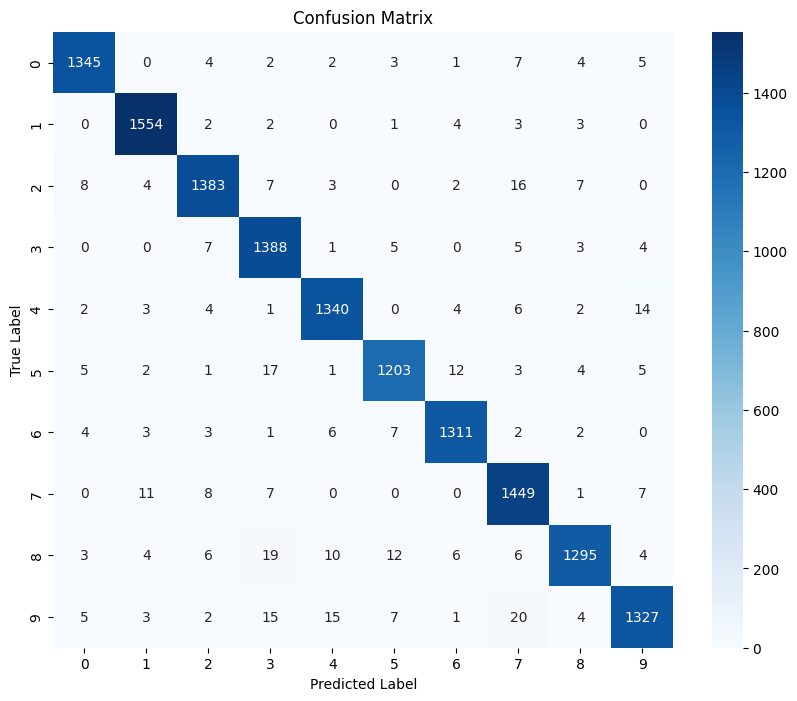


Training with 90.0:9.999999999999998 split

Testing relu activation with xavier initialization
Model Parameters - Trainable: 109,386, Non-trainable: 0
Epoch 1/25
loss: 0.3409 - accuracy: 0.9027
val_loss: 0.3311 - val_accuracy: 0.9058
Epoch 2/25
loss: 0.2910 - accuracy: 0.9172
val_loss: 0.2864 - val_accuracy: 0.9182
Epoch 3/25
loss: 0.2659 - accuracy: 0.9212
val_loss: 0.2676 - val_accuracy: 0.9204
Epoch 4/25
loss: 0.2326 - accuracy: 0.9329
val_loss: 0.2352 - val_accuracy: 0.9329
Epoch 5/25
loss: 0.2040 - accuracy: 0.9407
val_loss: 0.2111 - val_accuracy: 0.9385
Epoch 6/25
loss: 0.1928 - accuracy: 0.9428
val_loss: 0.2008 - val_accuracy: 0.9417
Epoch 7/25
loss: 0.1693 - accuracy: 0.9517
val_loss: 0.1816 - val_accuracy: 0.9496
Epoch 8/25
loss: 0.1512 - accuracy: 0.9563
val_loss: 0.1658 - val_accuracy: 0.9525
Epoch 9/25
loss: 0.1462 - accuracy: 0.9576
val_loss: 0.1627 - val_accuracy: 0.9536
Epoch 10/25
loss: 0.1299 - accuracy: 0.9625
val_loss: 0.1519 - val_accuracy: 0.9575
Epoch 11/25
loss:

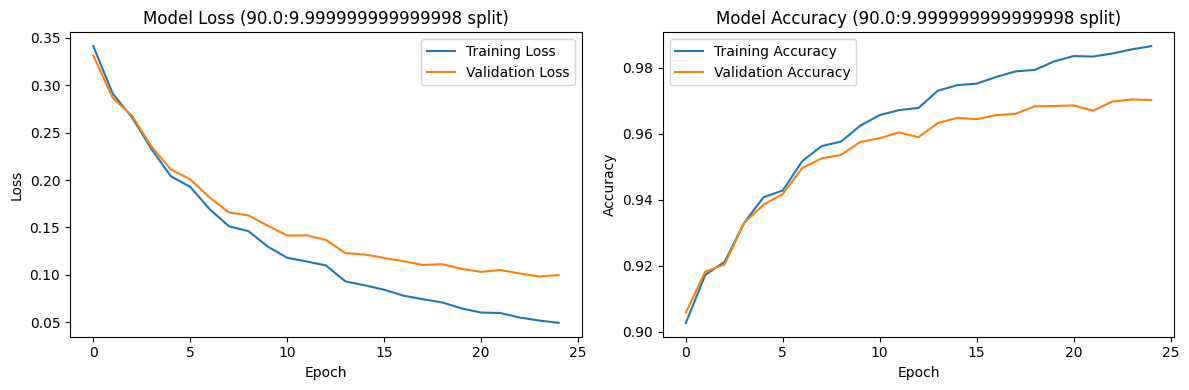

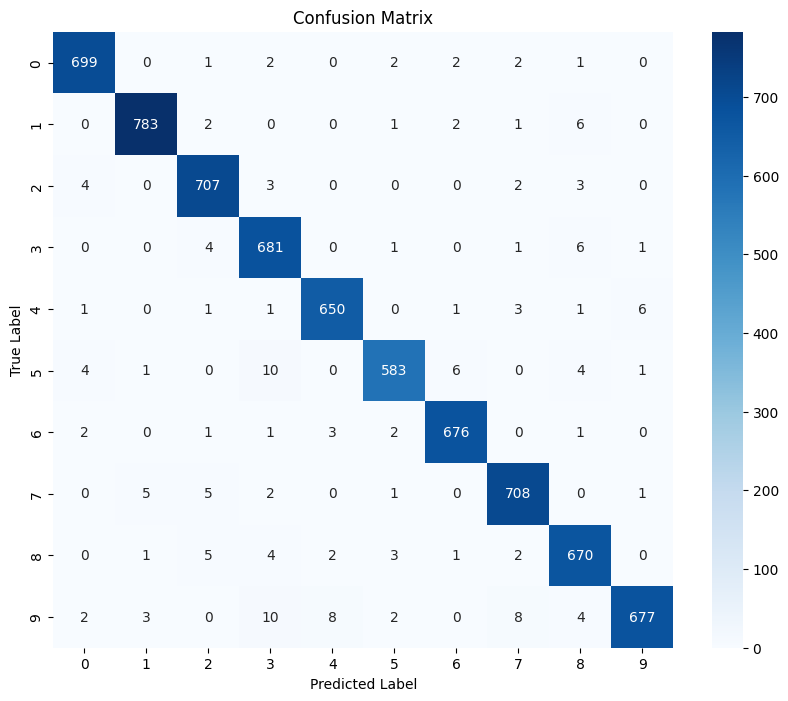


Testing relu activation with he initialization
Model Parameters - Trainable: 109,386, Non-trainable: 0
Epoch 1/25
loss: 0.3154 - accuracy: 0.9093
val_loss: 0.3084 - val_accuracy: 0.9121
Epoch 2/25
loss: 0.2644 - accuracy: 0.9247
val_loss: 0.2625 - val_accuracy: 0.9269
Epoch 3/25
loss: 0.2302 - accuracy: 0.9324
val_loss: 0.2357 - val_accuracy: 0.9306
Epoch 4/25
loss: 0.2006 - accuracy: 0.9418
val_loss: 0.2092 - val_accuracy: 0.9413
Epoch 5/25
loss: 0.1758 - accuracy: 0.9490
val_loss: 0.1894 - val_accuracy: 0.9457
Epoch 6/25
loss: 0.1660 - accuracy: 0.9514
val_loss: 0.1797 - val_accuracy: 0.9475
Epoch 7/25
loss: 0.1451 - accuracy: 0.9587
val_loss: 0.1637 - val_accuracy: 0.9544
Epoch 8/25
loss: 0.1299 - accuracy: 0.9621
val_loss: 0.1517 - val_accuracy: 0.9562
Epoch 9/25
loss: 0.1282 - accuracy: 0.9627
val_loss: 0.1513 - val_accuracy: 0.9566
Epoch 10/25
loss: 0.1102 - accuracy: 0.9683
val_loss: 0.1393 - val_accuracy: 0.9607
Epoch 11/25
loss: 0.1019 - accuracy: 0.9710
val_loss: 0.1315 - va

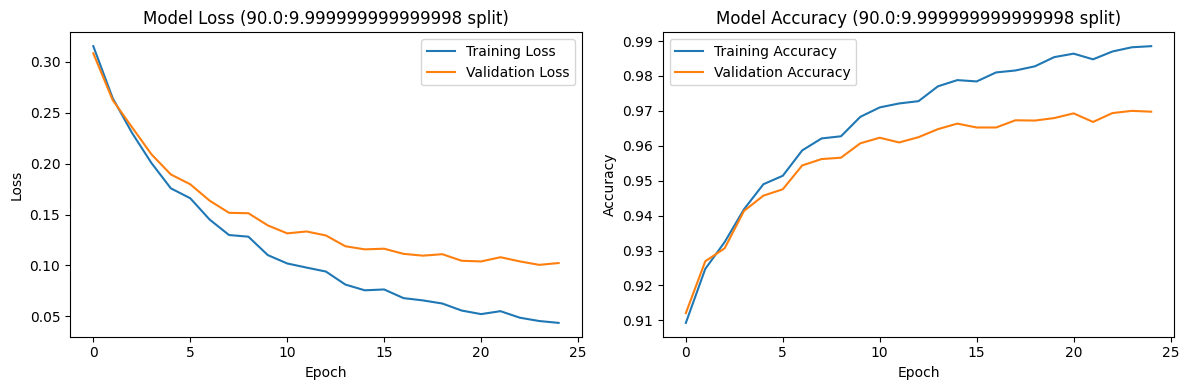

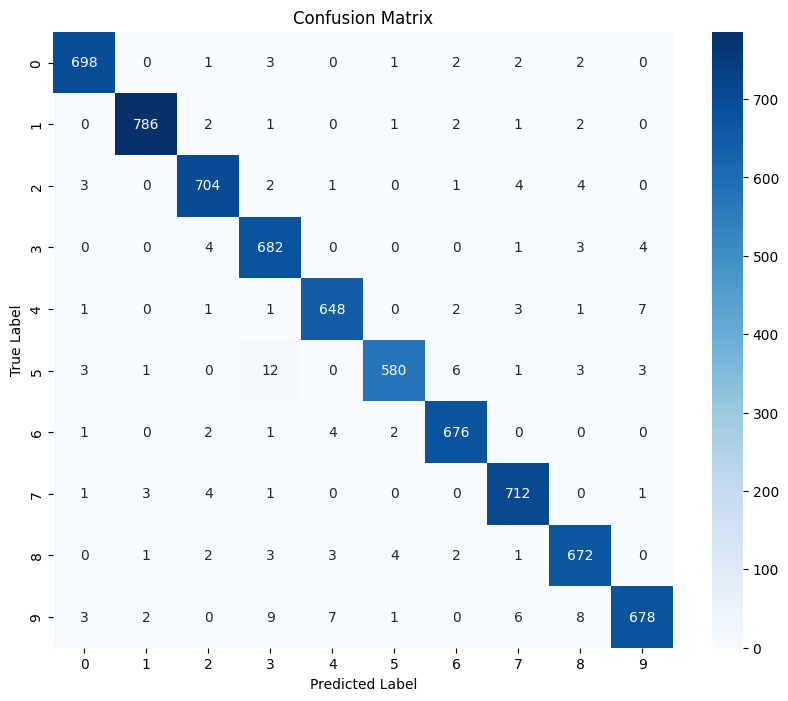


Testing tanh activation with xavier initialization
Model Parameters - Trainable: 109,386, Non-trainable: 0
Epoch 1/25
loss: 0.4058 - accuracy: 0.8911
val_loss: 0.3908 - val_accuracy: 0.8948
Epoch 2/25
loss: 0.3022 - accuracy: 0.9139
val_loss: 0.2951 - val_accuracy: 0.9152
Epoch 3/25
loss: 0.2617 - accuracy: 0.9236
val_loss: 0.2590 - val_accuracy: 0.9261
Epoch 4/25
loss: 0.2310 - accuracy: 0.9329
val_loss: 0.2307 - val_accuracy: 0.9334
Epoch 5/25
loss: 0.2054 - accuracy: 0.9406
val_loss: 0.2087 - val_accuracy: 0.9389
Epoch 6/25
loss: 0.1893 - accuracy: 0.9438
val_loss: 0.1943 - val_accuracy: 0.9437
Epoch 7/25
loss: 0.1697 - accuracy: 0.9511
val_loss: 0.1774 - val_accuracy: 0.9494
Epoch 8/25
loss: 0.1544 - accuracy: 0.9555
val_loss: 0.1651 - val_accuracy: 0.9529
Epoch 9/25
loss: 0.1438 - accuracy: 0.9589
val_loss: 0.1562 - val_accuracy: 0.9550
Epoch 10/25
loss: 0.1301 - accuracy: 0.9629
val_loss: 0.1465 - val_accuracy: 0.9585
Epoch 11/25
loss: 0.1211 - accuracy: 0.9657
val_loss: 0.1388 

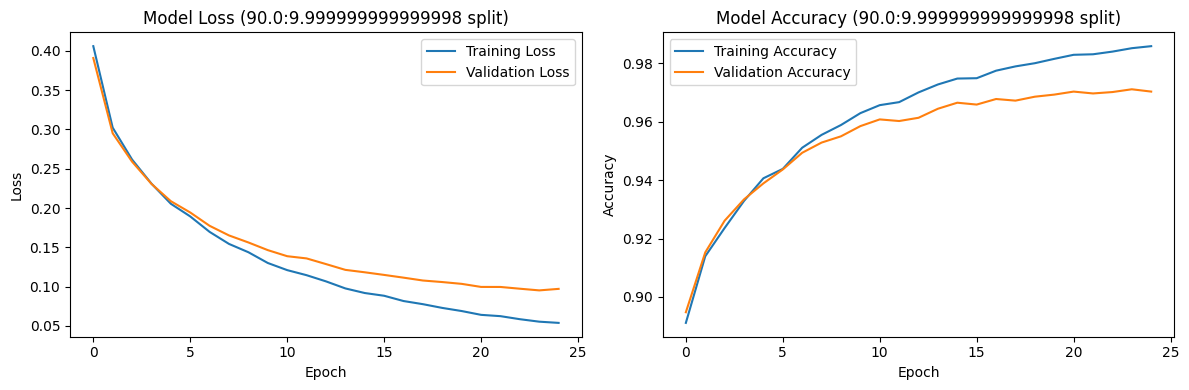

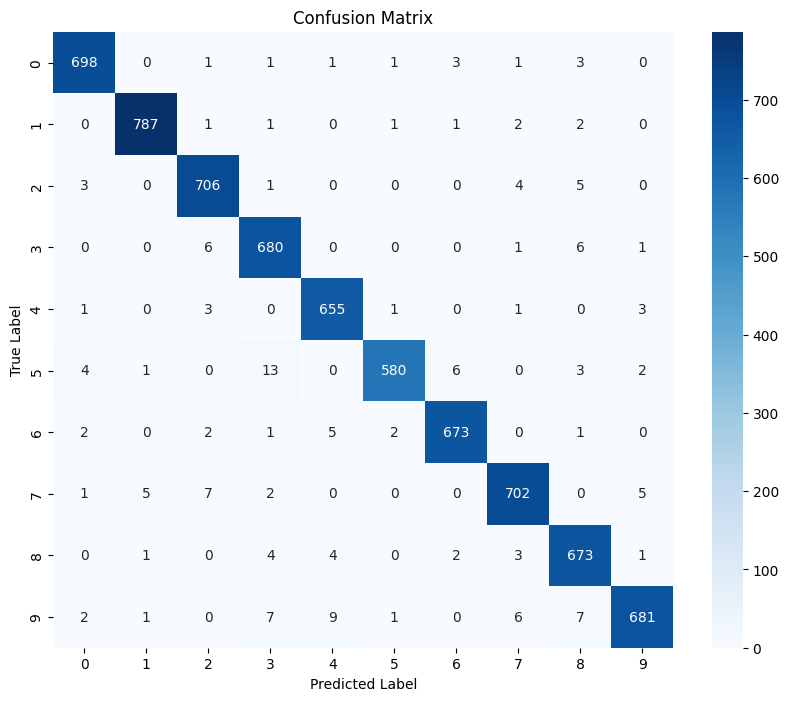


Testing tanh activation with he initialization
Model Parameters - Trainable: 109,386, Non-trainable: 0
Epoch 1/25
loss: 0.3559 - accuracy: 0.9016
val_loss: 0.3448 - val_accuracy: 0.9051
Epoch 2/25
loss: 0.2747 - accuracy: 0.9218
val_loss: 0.2714 - val_accuracy: 0.9219
Epoch 3/25
loss: 0.2360 - accuracy: 0.9330
val_loss: 0.2376 - val_accuracy: 0.9312
Epoch 4/25
loss: 0.2061 - accuracy: 0.9411
val_loss: 0.2102 - val_accuracy: 0.9392
Epoch 5/25
loss: 0.1818 - accuracy: 0.9479
val_loss: 0.1894 - val_accuracy: 0.9452
Epoch 6/25
loss: 0.1679 - accuracy: 0.9513
val_loss: 0.1766 - val_accuracy: 0.9482
Epoch 7/25
loss: 0.1497 - accuracy: 0.9572
val_loss: 0.1615 - val_accuracy: 0.9539
Epoch 8/25
loss: 0.1366 - accuracy: 0.9612
val_loss: 0.1508 - val_accuracy: 0.9564
Epoch 9/25
loss: 0.1271 - accuracy: 0.9640
val_loss: 0.1428 - val_accuracy: 0.9596
Epoch 10/25
loss: 0.1160 - accuracy: 0.9673
val_loss: 0.1353 - val_accuracy: 0.9616
Epoch 11/25
loss: 0.1081 - accuracy: 0.9699
val_loss: 0.1284 - va

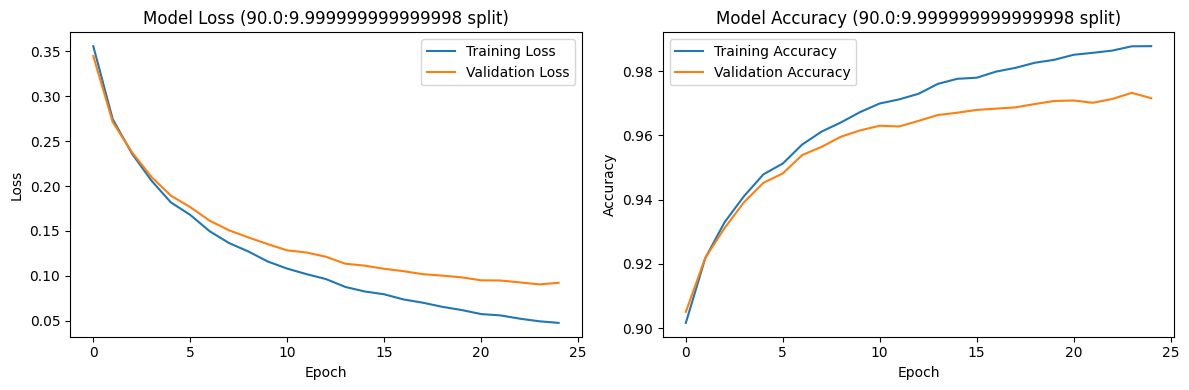

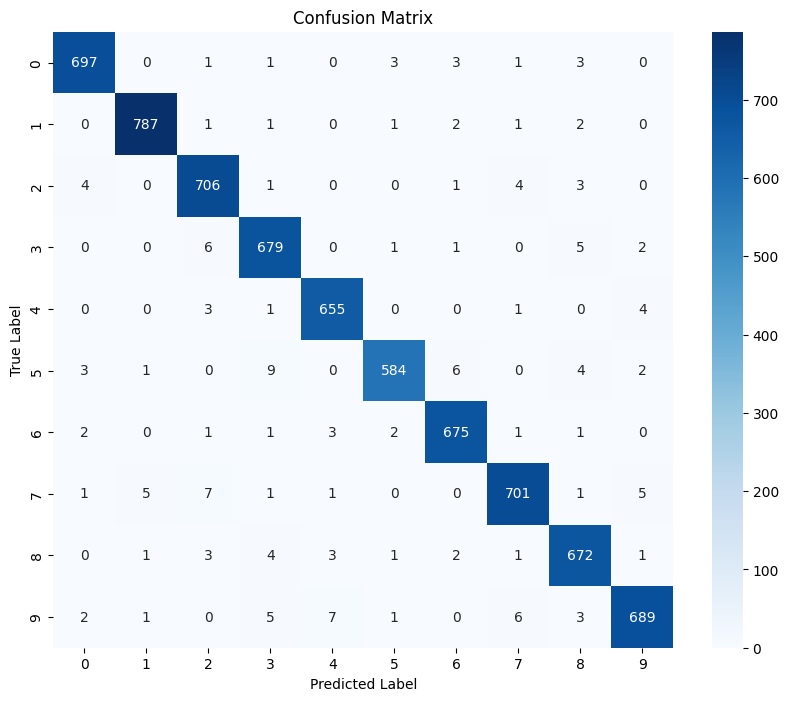


Testing leaky_relu activation with xavier initialization
Model Parameters - Trainable: 109,386, Non-trainable: 0
Epoch 1/25
loss: 0.3411 - accuracy: 0.9026
val_loss: 0.3313 - val_accuracy: 0.9054
Epoch 2/25
loss: 0.2915 - accuracy: 0.9170
val_loss: 0.2869 - val_accuracy: 0.9183
Epoch 3/25
loss: 0.2665 - accuracy: 0.9208
val_loss: 0.2682 - val_accuracy: 0.9202
Epoch 4/25
loss: 0.2333 - accuracy: 0.9327
val_loss: 0.2361 - val_accuracy: 0.9324
Epoch 5/25
loss: 0.2049 - accuracy: 0.9404
val_loss: 0.2120 - val_accuracy: 0.9380
Epoch 6/25
loss: 0.1938 - accuracy: 0.9423
val_loss: 0.2017 - val_accuracy: 0.9413
Epoch 7/25
loss: 0.1702 - accuracy: 0.9514
val_loss: 0.1822 - val_accuracy: 0.9499
Epoch 8/25
loss: 0.1523 - accuracy: 0.9559
val_loss: 0.1667 - val_accuracy: 0.9526
Epoch 9/25
loss: 0.1473 - accuracy: 0.9572
val_loss: 0.1635 - val_accuracy: 0.9537
Epoch 10/25
loss: 0.1308 - accuracy: 0.9621
val_loss: 0.1526 - val_accuracy: 0.9571
Epoch 11/25
loss: 0.1192 - accuracy: 0.9656
val_loss: 0

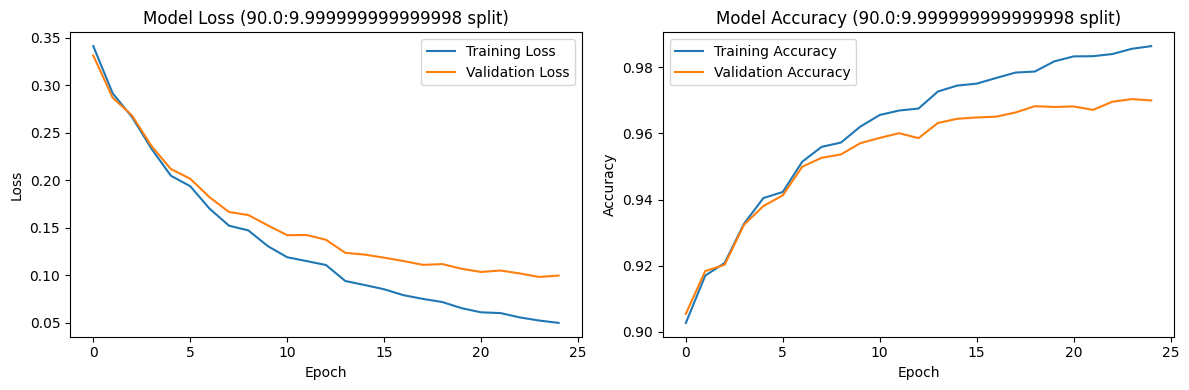

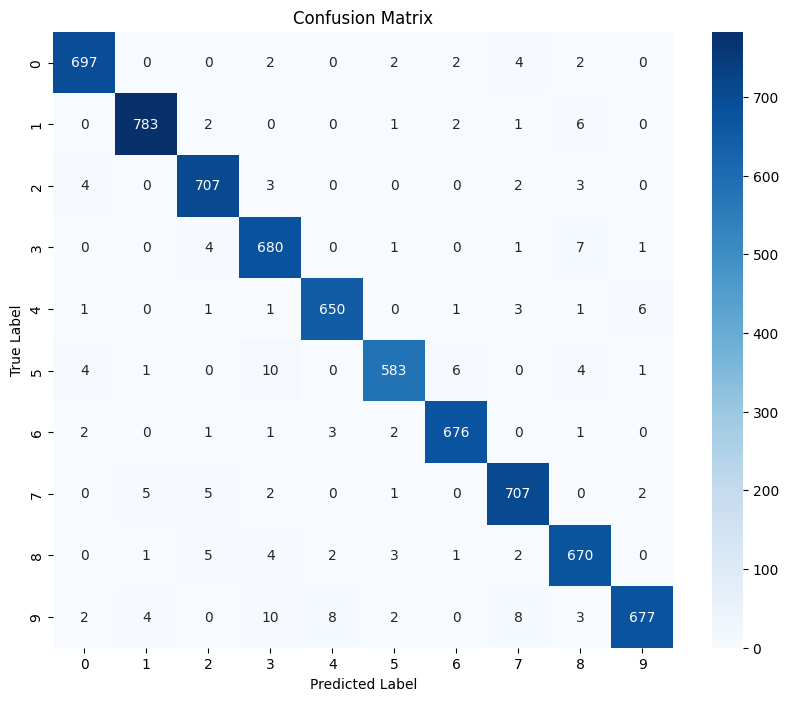


Testing leaky_relu activation with he initialization
Model Parameters - Trainable: 109,386, Non-trainable: 0
Epoch 1/25
loss: 0.3159 - accuracy: 0.9090
val_loss: 0.3090 - val_accuracy: 0.9120
Epoch 2/25
loss: 0.2650 - accuracy: 0.9242
val_loss: 0.2630 - val_accuracy: 0.9263
Epoch 3/25
loss: 0.2314 - accuracy: 0.9322
val_loss: 0.2368 - val_accuracy: 0.9302
Epoch 4/25
loss: 0.2018 - accuracy: 0.9414
val_loss: 0.2104 - val_accuracy: 0.9410
Epoch 5/25
loss: 0.1764 - accuracy: 0.9487
val_loss: 0.1899 - val_accuracy: 0.9452
Epoch 6/25
loss: 0.1671 - accuracy: 0.9509
val_loss: 0.1804 - val_accuracy: 0.9471
Epoch 7/25
loss: 0.1466 - accuracy: 0.9587
val_loss: 0.1649 - val_accuracy: 0.9543
Epoch 8/25
loss: 0.1313 - accuracy: 0.9617
val_loss: 0.1528 - val_accuracy: 0.9558
Epoch 9/25
loss: 0.1292 - accuracy: 0.9624
val_loss: 0.1516 - val_accuracy: 0.9563
Epoch 10/25
loss: 0.1115 - accuracy: 0.9680
val_loss: 0.1402 - val_accuracy: 0.9608
Epoch 11/25
loss: 0.1031 - accuracy: 0.9705
val_loss: 0.132

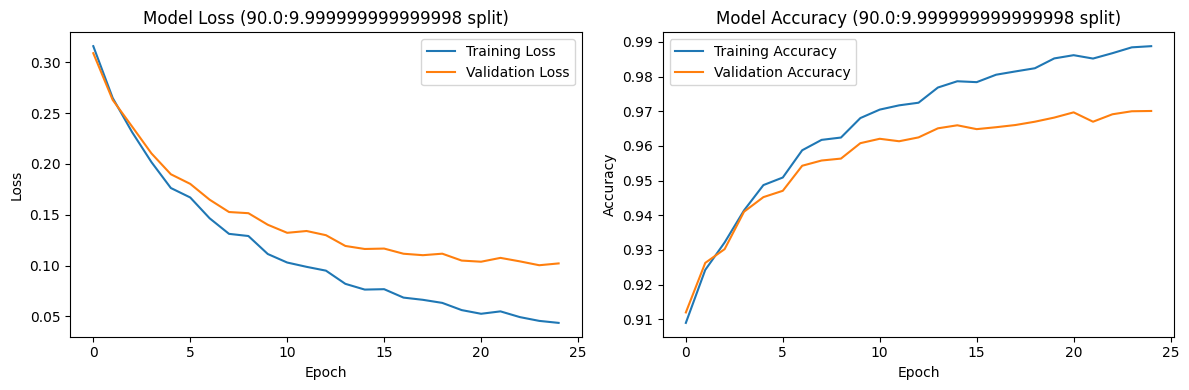

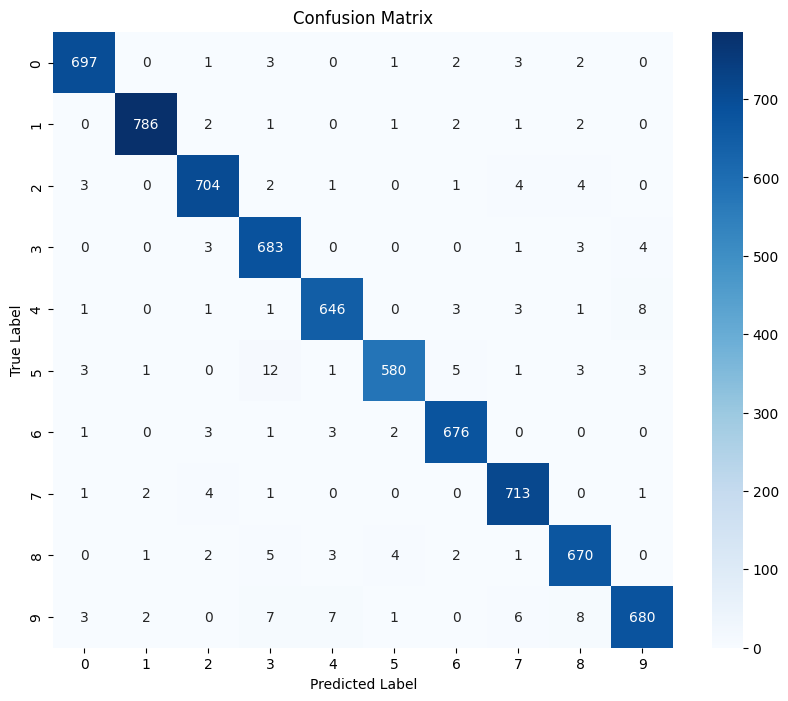


Best configurations by test accuracy:
    split_ratio activation initialization  test_accuracy  training_time  \
15          0.9       tanh             he       0.977857      74.082479   
13          0.9       relu             he       0.976571      73.961319   
14          0.9       tanh         xavier       0.976429     123.437454   

    trainable_params  non_trainable_params  
15            109386                     0  
13            109386                     0  
14            109386                     0  


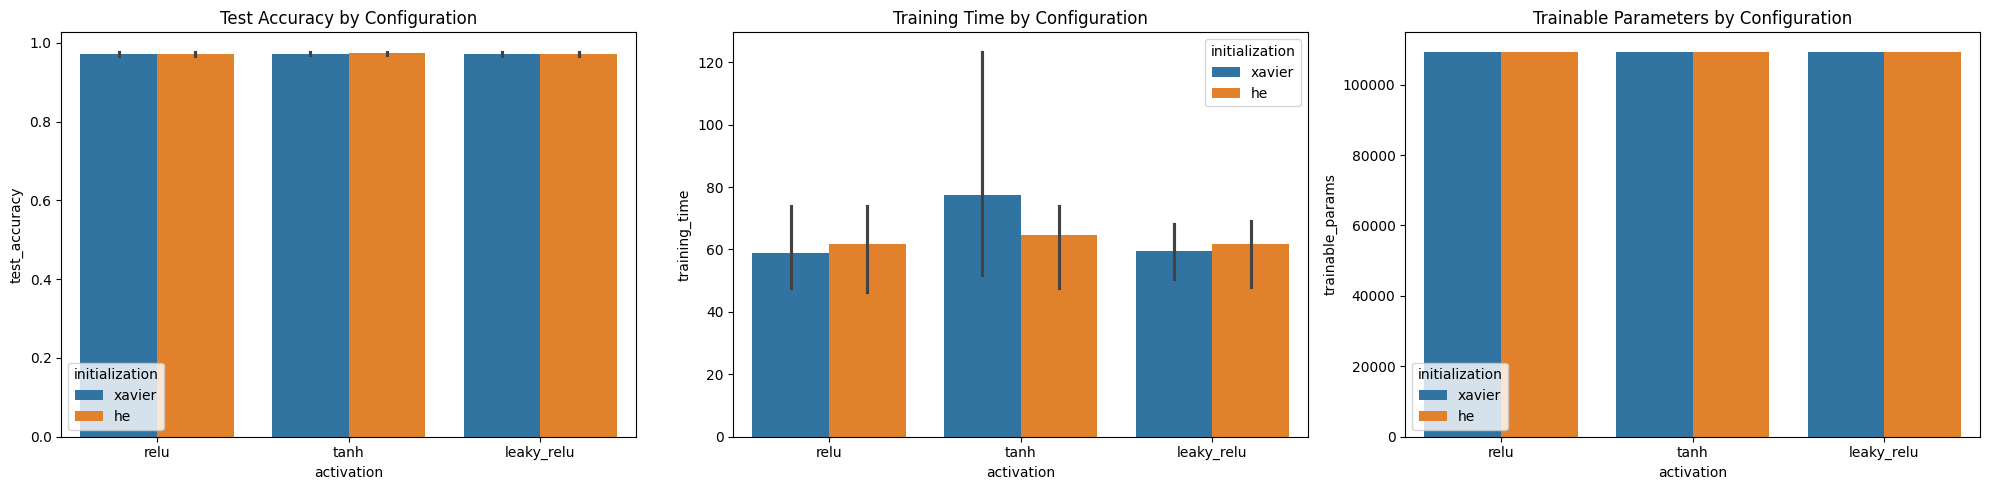


Parameter Summary by Configuration:
                           trainable_params  non_trainable_params  \
activation initialization                                           
leaky_relu he                      109386.0                   0.0   
           xavier                  109386.0                   0.0   
relu       he                      109386.0                   0.0   
           xavier                  109386.0                   0.0   
tanh       he                      109386.0                   0.0   
           xavier                  109386.0                   0.0   

                           total_params  
activation initialization                
leaky_relu he                  109386.0  
           xavier              109386.0  
relu       he                  109386.0  
           xavier              109386.0  
tanh       he                  109386.0  
           xavier              109386.0  


In [12]:
def main():
    """Load MNIST data"""
    X, y = load_and_preprocess_mnist()
    results = []

    """Train-test splits as randomized 70:30, 80:20 and 90:10"""
    splits = [0.7, 0.8, 0.9]
    activations = ['relu', 'tanh', 'leaky_relu']
    initializations = ['xavier', 'he']

    for split in splits:
        print(f"\nTraining with {split*100}:{(1-split)*100} split")
        split_idx = int(len(X) * split)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]

        for activation in activations:
            for init in initializations:
                print(f"\nTesting {activation} activation with {init} initialization")

                """Training Time"""
                start_time = time.time()

                network = NeuralNetwork(
                    [784, 128, 64, 10],
                    seed=32,
                    activation=activation,
                    initialization=init
                )

                """Parameter count before training"""
                trainable_params, non_trainable_params = network.get_params_count()
                print(f"Model Parameters - Trainable: {trainable_params:,}, Non-trainable: {non_trainable_params:,}")

                history = network.train(
                    X_train,
                    y_train,
                    batch_size=24,
                    epochs=25,
                    validation_split=0.2,
                    early_stopping_patience=5,
                    lambda_reg=0.01
                )
                training_time = time.time() - start_time
                eval_metrics = network.evaluate(X_test, y_test)
                result = {
                    'split_ratio': split,
                    'activation': activation,
                    'initialization': init,
                    'training_time': training_time,
                    'final_train_loss': history['loss'][-1],
                    'final_train_accuracy': history['accuracy'][-1],
                    'final_val_loss': history['val_loss'][-1],
                    'final_val_accuracy': history['val_accuracy'][-1],
                    'test_loss': eval_metrics['test_loss'],
                    'test_accuracy': eval_metrics['test_accuracy'],
                    'trainable_params': trainable_params,
                    'non_trainable_params': non_trainable_params,
                    'total_params': trainable_params + non_trainable_params,
                    'precision_macro': eval_metrics['classification_report']['macro avg']['precision'],
                    'recall_macro': eval_metrics['classification_report']['macro avg']['recall'],
                    'f1_macro': eval_metrics['classification_report']['macro avg']['f1-score']
                }

                results.append(result)
                print(f"\nResults for {activation} activation with {init} initialization:")
                print(f"Training time: {training_time:.2f} seconds")
                print(f"Parameters - Trainable: {trainable_params:,}, Non-trainable: {non_trainable_params:,}")
                print(f"Final train accuracy: {result['final_train_accuracy']:.4f}")
                print(f"Final validation accuracy: {result['final_val_accuracy']:.4f}")
                print(f"Test accuracy: {result['test_accuracy']:.4f}")
                print(f"Macro F1 Score: {result['f1_macro']:.4f}")
                plot_training_history(history, split)
                y_pred = np.argmax(network.forward(X_test), axis=1)
                plot_confusion_matrix(y_test, y_pred)

    """Results converted to DataFrame"""
    results_df = pd.DataFrame(results)
    results_df.to_csv('neural_network_results.csv', index=False)

    print("\nBest configurations by test accuracy:")
    print(results_df.nlargest(3, 'test_accuracy')[
        ['split_ratio', 'activation', 'initialization', 'test_accuracy',
         'training_time', 'trainable_params', 'non_trainable_params']
    ])

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    sns.barplot(data=results_df, x='activation', y='test_accuracy', hue='initialization')
    plt.title('Test Accuracy by Configuration')
    plt.subplot(1, 3, 2)
    sns.barplot(data=results_df, x='activation', y='training_time', hue='initialization')
    plt.title('Training Time by Configuration')
    plt.subplot(1, 3, 3)
    sns.barplot(data=results_df, x='activation', y='trainable_params', hue='initialization')
    plt.title('Trainable Parameters by Configuration')
    plt.tight_layout()
    plt.show()

    """Summary table of parameters by configuration"""

    param_summary = results_df.groupby(['activation', 'initialization'])[
        ['trainable_params', 'non_trainable_params', 'total_params']
    ].mean().round(0)

    print("\nParameter Summary by Configuration:")
    print(param_summary)

if __name__ == "__main__":
    main()